In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2022
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2022-02-16,2022-02-26,14,Unknown/Unidentified,4140.06000,CDF,AIRPORT,"MULTIPOLYGON (((-118.33258 37.33500, -118.3329..."
1,2022-05-24,2022-05-24,14,Unknown/Unidentified,29.84678,CDF,DENIZ,"POLYGON ((-121.69741 39.37259, -121.69753 39.3..."
2,2022-06-13,2022-06-19,14,Unknown/Unidentified,589.86710,CDF,RANCHO,"POLYGON ((-122.45123 40.00960, -122.45114 40.0..."
3,2022-06-03,2022-06-03,7,Arson,28.68488,CDF,TOWER,"POLYGON ((-122.39886 37.67438, -122.39812 37.6..."
4,2022-06-28,2022-06-29,18,Escaped Prescribed Burn,309.47930,CDF,BURROWS,"POLYGON ((-122.53410 39.74777, -122.53402 39.7..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2022-02-16,2022-02-26,14,Unknown/Unidentified,4140.06000
1,2022-05-24,2022-05-24,14,Unknown/Unidentified,29.84678
2,2022-06-13,2022-06-19,14,Unknown/Unidentified,589.86710
3,2022-06-03,2022-06-03,7,Arson,28.68488
4,2022-06-28,2022-06-29,18,Escaped Prescribed Burn,309.47930


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2022-02-16,2022-02-26,14,Unknown/Unidentified,4140.06000,10 days
1,2022-05-24,2022-05-24,14,Unknown/Unidentified,29.84678,0 days
2,2022-06-13,2022-06-19,14,Unknown/Unidentified,589.86710,6 days
3,2022-06-03,2022-06-03,7,Arson,28.68488,0 days
4,2022-06-28,2022-06-29,18,Escaped Prescribed Burn,309.47930,1 days


In [7]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,85,2022-08-01,2022-08-02,1,Lightning,3.141882,1 days
1,87,2022-09-07,2022-09-08,1,Lightning,296.951700,1 days
2,76,2022-07-30,2022-07-31,1,Lightning,30.946690,1 days
3,83,2022-07-31,2022-08-01,1,Lightning,62.630280,1 days
4,143,2022-06-23,2022-06-25,1,Lightning,21.388030,2 days


In [8]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,28.50,1348.87,16
2,Equipment Use,1.55,45.18,29
3,Smoking,0.00,37.56,1
4,Campfire,2.50,57.17,6
5,Debris,3.43,114.51,7
6,Railroad,0.00,63.71,1
7,Arson,6.50,275.21,24
9,Miscellaneous,7.37,2631.10,30
10,Vehicle,2.54,98.22,37


In [9]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2022.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,28.50,1348.87,16
2,Equipment Use,1.55,45.18,29
3,Smoking,0.00,37.56,1
4,Campfire,2.50,57.17,6
5,Debris,3.43,114.51,7
6,Railroad,0.00,63.71,1
7,Arson,6.50,275.21,24
10,Vehicle,2.54,98.22,37
11,Powerline,4.55,61.50,11


In [10]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,26.6,1138.39,125
1,Natural,28.5,1348.87,16


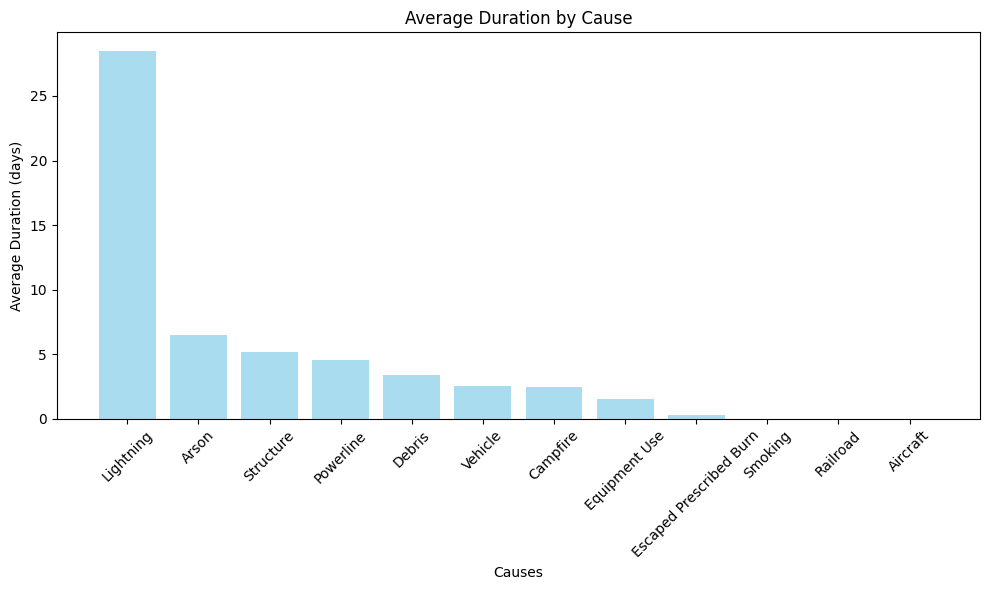

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

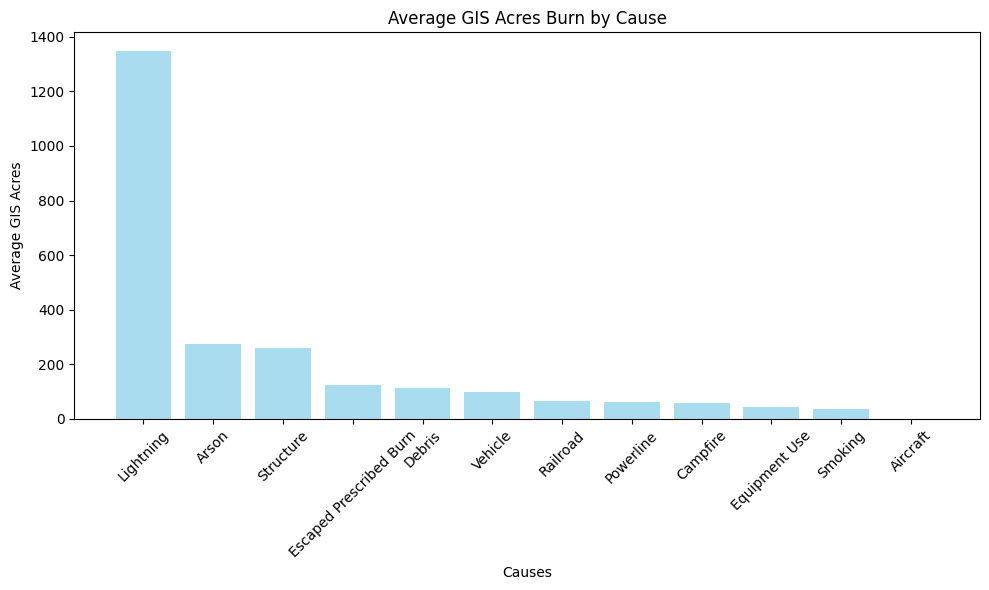

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

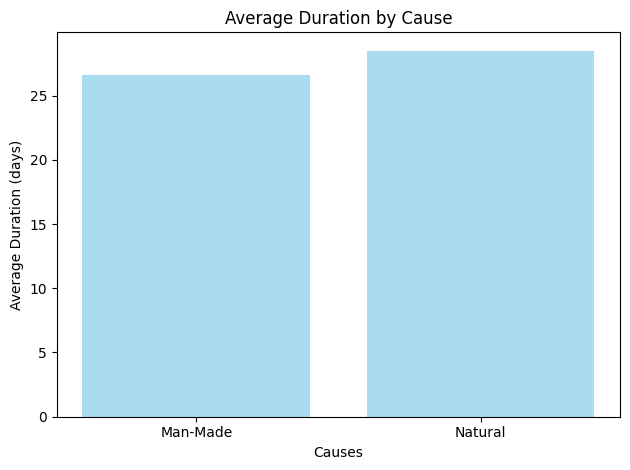

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

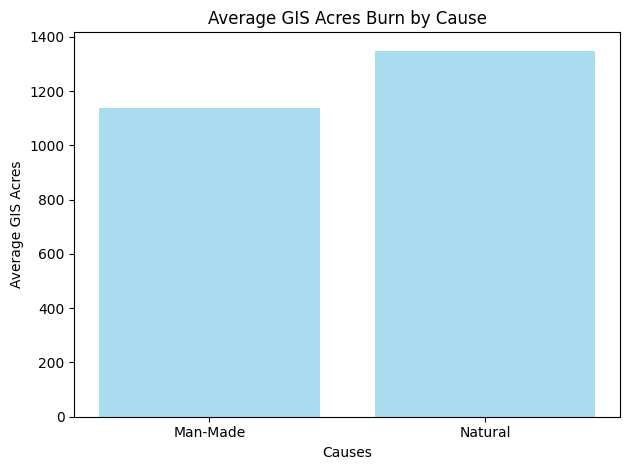

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

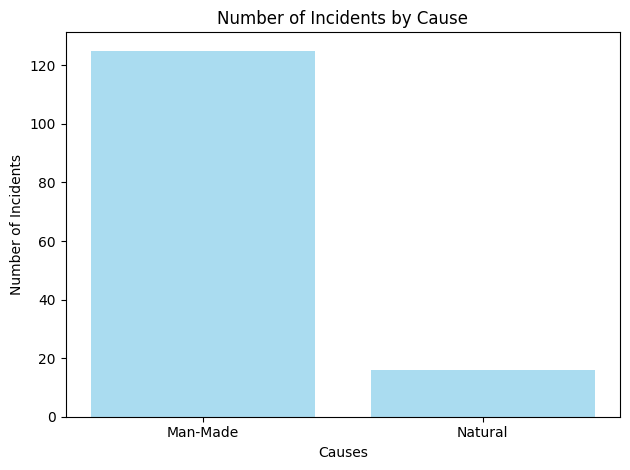

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

In [16]:
# Replace 'vehicle' and 'railroad' with 'transportation' in 'causes' column
fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad', 'Aircraft'], 'Transportation', inplace=True)

C:\Users\Long\AppData\Local\Temp\ipykernel_43580\3135604390.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad', 'Aircraft'], 'Transportation', inplace=True)


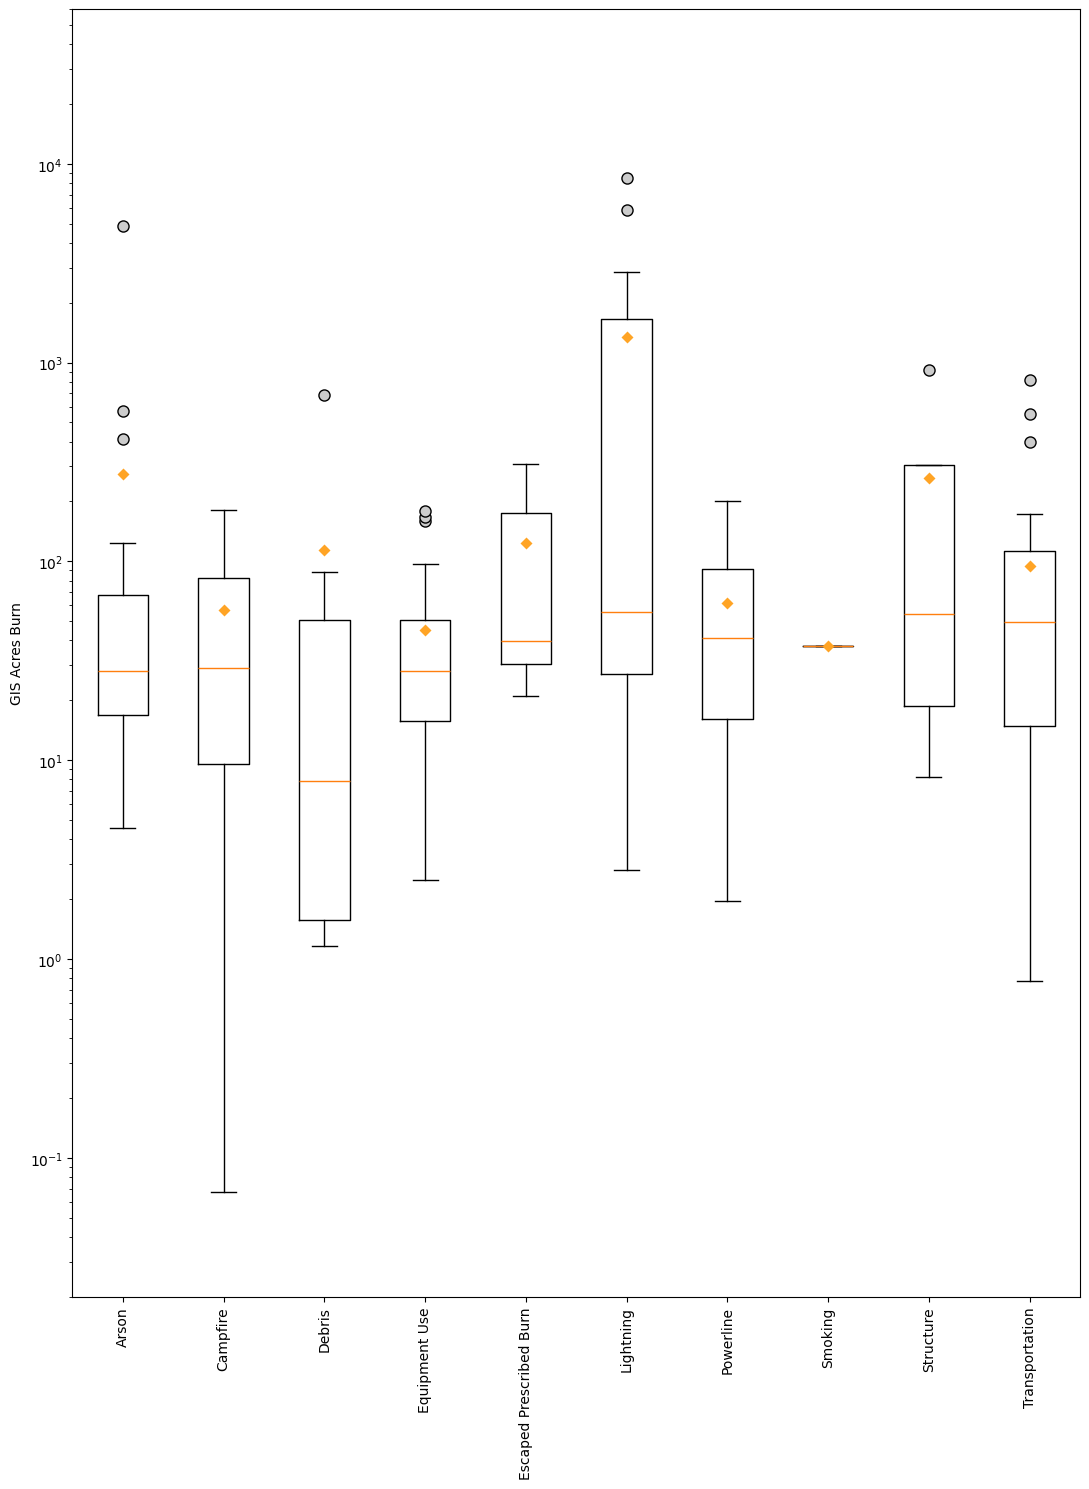

In [17]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.02, 60000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()